# Pytorch tutorial

In [69]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn

## Tensors
Tensors are similar to NumPy’s ndarrays, with the addition being that
Tensors can also be used on a GPU to accelerate computing. 

In [70]:
# Construct a 5x3 matrix, uninitialized:

x = torch.empty(5, 3)
print(x)

tensor([[ 0.0000e+00, -2.5244e-29, -1.0840e+32],
        [ 2.0005e+00,  4.1677e-08,  2.9914e+00],
        [ 9.3756e-38,  1.8903e-40,  5.1562e+06],
        [ 4.5759e-41,  5.1887e+06,  4.5759e-41],
        [ 4.8830e+06,  4.5759e-41,  4.9150e+06]])


In [71]:
# Construct a randomly initialized matrix:

x = torch.rand(5, 3)
print(x)

tensor([[0.2231, 0.3055, 0.8766],
        [0.1010, 0.3393, 0.6556],
        [0.2062, 0.1121, 0.9339],
        [0.7163, 0.5342, 0.0365],
        [0.1337, 0.7583, 0.6360]])


In [72]:
# Matrix multiplication
y = torch.rand(3,5)
prod = torch.matmul(x,y)
print(prod)

tensor([[0.8202, 0.4258, 1.1099, 0.7566, 0.0653],
        [0.6833, 0.3114, 0.8986, 0.5487, 0.0586],
        [0.6909, 0.4226, 1.0300, 0.7088, 0.0502],
        [0.6735, 0.2714, 0.5010, 0.7881, 0.0528],
        [1.0225, 0.3569, 1.1750, 0.7052, 0.0957]])


In [73]:
# Construct a tensor directly from data:

x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


In [74]:
# check a tensor shape

x.shape

torch.Size([2])

## Autograd: Automatic Differentiation


Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



Create a tensor and set ``requires_grad=True`` to track computation with it

In [75]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation

In [76]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.


In [77]:
print(y.grad_fn)


Do more operations on ``y``

In [78]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>) tensor(27., grad_fn=<MeanBackward1>)


## Gradients

Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.

In [79]:
out.backward()

Print gradients $\partial_x out$

In [80]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

## Data

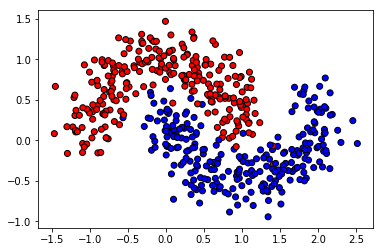

In [81]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

# visualisation
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)

## Neural Networks


Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

### Define the network


Let’s define this network:



In [82]:
class ANN(nn.Module):
    
    def __init__(self, n_hidden):
        super(ANN, self).__init__()
        self.i_h = nn.Sequential(nn.Linear(2, n_hidden), nn.Sigmoid())
        self.h_o = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid())
        
    def forward(self, x):
        h = self.i_h(x)
        output = self.h_o(h)
        return output
    
n_hidden = 30
net = ANN(n_hidden = n_hidden)
print(net)

ANN(
  (i_h): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (h_o): Sequential(
    (0): Linear(in_features=30, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()`` or by ``net.state_dict()``



In [83]:
print(net.state_dict())

OrderedDict([('i_h.0.weight', tensor([[-0.2645, -0.6908],
        [-0.3350, -0.0026],
        [-0.1226,  0.4988],
        [ 0.1797,  0.4881],
        [-0.6250, -0.6559],
        [-0.6886,  0.4029],
        [-0.4291,  0.5817],
        [-0.2100, -0.1007],
        [ 0.2326,  0.0098],
        [ 0.4205, -0.6837],
        [ 0.1215,  0.3040],
        [-0.2080, -0.5654],
        [-0.3492, -0.1854],
        [ 0.0833,  0.6366],
        [-0.5372, -0.3818],
        [ 0.3120,  0.5244],
        [ 0.3268, -0.3148],
        [ 0.2669,  0.4227],
        [-0.6769,  0.6316],
        [-0.2739,  0.6274],
        [ 0.0564, -0.0328],
        [ 0.0992, -0.0372],
        [-0.1334, -0.5226],
        [ 0.6993, -0.3472],
        [-0.6456, -0.5920],
        [ 0.2766,  0.3424],
        [ 0.0206, -0.2387],
        [-0.1596, -0.3584],
        [ 0.4853, -0.3625],
        [ 0.1741,  0.1184]])), ('i_h.0.bias', tensor([ 0.2241, -0.1941,  0.6102,  0.0404, -0.4046, -0.0225, -0.3229, -0.0117,
         0.2447, -0.6704,  0.293

Before proceeding further, let's recap all the classes we’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <https://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.BCELoss`` which computes the log-likelihood of the data assuming it's sampled from a Bernouilli distribution.

For example:

In [84]:
# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
target = torch.tensor(y, dtype=torch.float32).view(-1,1)

y_output = net(X_tensor)
loss_fn = nn.BCELoss(reduction="sum")
loss = loss_fn(y_output, target)
print(loss)



tensor(352.8538, grad_fn=<BinaryCrossEntropyBackward>)


Let's start follwing ``loss`` in the backward direction in its graph to see which functions created it.

In [85]:
print(loss.grad_fn)  # BCELoss
print(loss.grad_fn.next_functions[0][0])  # Sigmoid
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # Linear

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at the network's parameters




In [86]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('grad of parameters of network before backward')
for param in net.parameters():
    print(param.grad)

loss.backward()
print('grad of parameters of network after backward')
for param in net.parameters():
    print(param.grad)




grad of parameters of network before backward
None
None
None
None
grad of parameters of network after backward
tensor([[ 2.9994, -1.9788],
        [ 0.7742, -0.5637],
        [ 4.9235, -2.8696],
        [-1.3834,  0.9056],
        [-3.7884,  2.7924],
        [ 0.0621, -0.0531],
        [ 4.1568, -3.3091],
        [ 3.1654, -2.1641],
        [-1.5523,  1.0928],
        [ 0.5771, -0.3162],
        [ 4.5768, -3.0069],
        [-0.9646,  0.6052],
        [ 2.1215, -1.4435],
        [-2.8176,  1.9846],
        [ 2.4626, -1.7842],
        [-3.3556,  2.2715],
        [ 4.8248, -3.0217],
        [ 4.7783, -3.1865],
        [-1.6054,  1.1253],
        [-5.5677,  3.5438],
        [-1.8063,  1.2248],
        [ 2.3057, -1.5708],
        [-6.0610,  3.8380],
        [ 3.8238, -3.7048],
        [-4.3371,  3.2986],
        [-0.8440,  0.5771],
        [-6.1679,  4.1931],
        [-4.2225,  2.7971],
        [ 0.2093, -0.1298],
        [-0.7810,  0.5164]])
tensor([ 0.3549,  0.0441,  1.1640, -0.1775, -0.3

### Update the weights
Recall that the optimisation of the loss function using Stochastic Gradient Descent is performed as follows:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    
However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
Pytorch has the package ``torch.optim`` that
implements all these methods. Using it is very simple:



In [87]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.)
print('Value of parameters of network before optimizer step:')
for param in net.parameters():
    print(param)



Value of parameters of network before optimizer step:
Parameter containing:
tensor([[-0.2645, -0.6908],
        [-0.3350, -0.0026],
        [-0.1226,  0.4988],
        [ 0.1797,  0.4881],
        [-0.6250, -0.6559],
        [-0.6886,  0.4029],
        [-0.4291,  0.5817],
        [-0.2100, -0.1007],
        [ 0.2326,  0.0098],
        [ 0.4205, -0.6837],
        [ 0.1215,  0.3040],
        [-0.2080, -0.5654],
        [-0.3492, -0.1854],
        [ 0.0833,  0.6366],
        [-0.5372, -0.3818],
        [ 0.3120,  0.5244],
        [ 0.3268, -0.3148],
        [ 0.2669,  0.4227],
        [-0.6769,  0.6316],
        [-0.2739,  0.6274],
        [ 0.0564, -0.0328],
        [ 0.0992, -0.0372],
        [-0.1334, -0.5226],
        [ 0.6993, -0.3472],
        [-0.6456, -0.5920],
        [ 0.2766,  0.3424],
        [ 0.0206, -0.2387],
        [-0.1596, -0.3584],
        [ 0.4853, -0.3625],
        [ 0.1741,  0.1184]], requires_grad=True)
Parameter containing:
tensor([ 0.2241, -0.1941,  0.6102,  0.040

In [88]:
print('Value of parameters of network after optimizer step: ')
for param in net.parameters():
    print(param)

optimizer.step()

Value of parameters of network after optimizer step: 
Parameter containing:
tensor([[-0.2645, -0.6908],
        [-0.3350, -0.0026],
        [-0.1226,  0.4988],
        [ 0.1797,  0.4881],
        [-0.6250, -0.6559],
        [-0.6886,  0.4029],
        [-0.4291,  0.5817],
        [-0.2100, -0.1007],
        [ 0.2326,  0.0098],
        [ 0.4205, -0.6837],
        [ 0.1215,  0.3040],
        [-0.2080, -0.5654],
        [-0.3492, -0.1854],
        [ 0.0833,  0.6366],
        [-0.5372, -0.3818],
        [ 0.3120,  0.5244],
        [ 0.3268, -0.3148],
        [ 0.2669,  0.4227],
        [-0.6769,  0.6316],
        [-0.2739,  0.6274],
        [ 0.0564, -0.0328],
        [ 0.0992, -0.0372],
        [-0.1334, -0.5226],
        [ 0.6993, -0.3472],
        [-0.6456, -0.5920],
        [ 0.2766,  0.3424],
        [ 0.0206, -0.2387],
        [-0.1596, -0.3584],
        [ 0.4853, -0.3625],
        [ 0.1741,  0.1184]], requires_grad=True)
Parameter containing:
tensor([ 0.2241, -0.1941,  0.6102,  0.040

### Let's put everything together

In [89]:
n_hidden = 30
net = ANN(n_hidden = n_hidden)

# optimizer
lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# loss function
loss_fn = torch.nn.BCELoss(reduction="sum")

# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

# training
n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = net(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch%10 == 0:
        print("Iteration {}/{}, loss {:.4f}".format(epoch, n_epochs, loss.item()))

Iteration 0/10000, loss 365.0997
Iteration 10/10000, loss 296.3358
Iteration 20/10000, loss 254.2517
Iteration 30/10000, loss 223.5656
Iteration 40/10000, loss 202.3976
Iteration 50/10000, loss 187.8349
Iteration 60/10000, loss 177.4258
Iteration 70/10000, loss 169.6248
Iteration 80/10000, loss 163.5466
Iteration 90/10000, loss 158.6869
Iteration 100/10000, loss 154.7450
Iteration 110/10000, loss 151.5266
Iteration 120/10000, loss 148.8943
Iteration 130/10000, loss 146.7418
Iteration 140/10000, loss 144.9841
Iteration 150/10000, loss 143.5496
Iteration 160/10000, loss 142.3793
Iteration 170/10000, loss 141.4240
Iteration 180/10000, loss 140.6436
Iteration 190/10000, loss 140.0048
Iteration 200/10000, loss 139.4809
Iteration 210/10000, loss 139.0502
Iteration 220/10000, loss 138.6951
Iteration 230/10000, loss 138.4019
Iteration 240/10000, loss 138.1588
Iteration 250/10000, loss 137.9567
Iteration 260/10000, loss 137.7883
Iteration 270/10000, loss 137.6475
Iteration 280/10000, loss 137.5

Iteration 2520/10000, loss 64.2761
Iteration 2530/10000, loss 64.0126
Iteration 2540/10000, loss 63.7530
Iteration 2550/10000, loss 63.4971
Iteration 2560/10000, loss 63.2448
Iteration 2570/10000, loss 62.9961
Iteration 2580/10000, loss 62.7509
Iteration 2590/10000, loss 62.5091
Iteration 2600/10000, loss 62.2708
Iteration 2610/10000, loss 62.0357
Iteration 2620/10000, loss 61.8039
Iteration 2630/10000, loss 61.5752
Iteration 2640/10000, loss 61.3497
Iteration 2650/10000, loss 61.1273
Iteration 2660/10000, loss 60.9079
Iteration 2670/10000, loss 60.6915
Iteration 2680/10000, loss 60.4779
Iteration 2690/10000, loss 60.2672
Iteration 2700/10000, loss 60.0592
Iteration 2710/10000, loss 59.8541
Iteration 2720/10000, loss 59.6516
Iteration 2730/10000, loss 59.4518
Iteration 2740/10000, loss 59.2546
Iteration 2750/10000, loss 59.0599
Iteration 2760/10000, loss 58.8677
Iteration 2770/10000, loss 58.6780
Iteration 2780/10000, loss 58.4907
Iteration 2790/10000, loss 58.3057
Iteration 2800/10000

Iteration 5050/10000, loss 41.5199
Iteration 5060/10000, loss 41.4911
Iteration 5070/10000, loss 41.4626
Iteration 5080/10000, loss 41.4341
Iteration 5090/10000, loss 41.4059
Iteration 5100/10000, loss 41.3778
Iteration 5110/10000, loss 41.3499
Iteration 5120/10000, loss 41.3221
Iteration 5130/10000, loss 41.2945
Iteration 5140/10000, loss 41.2671
Iteration 5150/10000, loss 41.2398
Iteration 5160/10000, loss 41.2126
Iteration 5170/10000, loss 41.1856
Iteration 5180/10000, loss 41.1588
Iteration 5190/10000, loss 41.1321
Iteration 5200/10000, loss 41.1056
Iteration 5210/10000, loss 41.0792
Iteration 5220/10000, loss 41.0529
Iteration 5230/10000, loss 41.0269
Iteration 5240/10000, loss 41.0009
Iteration 5250/10000, loss 40.9751
Iteration 5260/10000, loss 40.9494
Iteration 5270/10000, loss 40.9239
Iteration 5280/10000, loss 40.8985
Iteration 5290/10000, loss 40.8732
Iteration 5300/10000, loss 40.8481
Iteration 5310/10000, loss 40.8231
Iteration 5320/10000, loss 40.7982
Iteration 5330/10000

Iteration 7450/10000, loss 37.4492
Iteration 7460/10000, loss 37.4391
Iteration 7470/10000, loss 37.4291
Iteration 7480/10000, loss 37.4191
Iteration 7490/10000, loss 37.4091
Iteration 7500/10000, loss 37.3993
Iteration 7510/10000, loss 37.3894
Iteration 7520/10000, loss 37.3795
Iteration 7530/10000, loss 37.3697
Iteration 7540/10000, loss 37.3598
Iteration 7550/10000, loss 37.3501
Iteration 7560/10000, loss 37.3404
Iteration 7570/10000, loss 37.3307
Iteration 7580/10000, loss 37.3210
Iteration 7590/10000, loss 37.3113
Iteration 7600/10000, loss 37.3017
Iteration 7610/10000, loss 37.2921
Iteration 7620/10000, loss 37.2826
Iteration 7630/10000, loss 37.2730
Iteration 7640/10000, loss 37.2635
Iteration 7650/10000, loss 37.2541
Iteration 7660/10000, loss 37.2446
Iteration 7670/10000, loss 37.2352
Iteration 7680/10000, loss 37.2259
Iteration 7690/10000, loss 37.2165
Iteration 7700/10000, loss 37.2072
Iteration 7710/10000, loss 37.1979
Iteration 7720/10000, loss 37.1886
Iteration 7730/10000

... and we plot the result

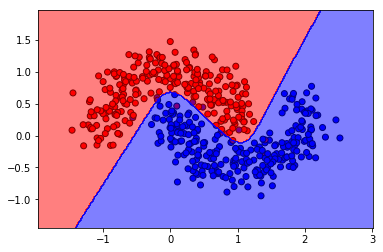

In [90]:
# plotting
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xx_tensor, yy_tensor = torch.tensor(xx, dtype=torch.float), torch.tensor(yy, dtype=torch.float)
Z = net(torch.stack([xx_tensor.flatten(), yy_tensor.flatten()], 1))
Z = Z.detach().numpy()
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)